In [25]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
%pip install plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, auc

# Cargar el conjunto de datos
df = pd.read_csv("../data/processed/clientes_banco.csv")


# extraigo la variable a predecir
x = df.drop('permanencia', axis=1) 
y = df['permanencia']  


Note: you may need to restart the kernel to use updated packages.


In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

random_forest = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=42)) ])

random_forest.fit(x_train, y_train)


# Serializo el modelo con pickle
with open("../model/random_forest_model.pkl", "wb") as f:
    pickle.dump(random_forest, f)

# Hacer predicciones en el conjunto de datos de prueba
random_forest_prediction = random_forest.predict(x_test)

f1_cross_val_scores = cross_val_score(random_forest,x_train,y_train,cv=5,scoring='f1')

fig = make_subplots(rows=1, cols=1,shared_xaxes=True,subplot_titles=('Random Forest score'))
fig.add_trace(
    go.Scatter(x=list(range(0,len(f1_cross_val_scores))),y=f1_cross_val_scores,name='Random Forest'),
    row=1, col=1
)

fig.update_layout(height=500, width=900, title_text="Validación cruzada de los 5 pliegues")
fig.update_yaxes(title_text="F1 Score")
fig.show()

In [27]:




fig = go.Figure(data=[go.Table(header=dict(values=['<b>Modelo<b>', '<b>F1 Score<b>']),                 
cells=dict(values=[['<b>Random Forest<b>'], [np.round(f1(random_forest_prediction,y_test),2)]]))])
fig.update_layout(title='Resultados')
fig.show()



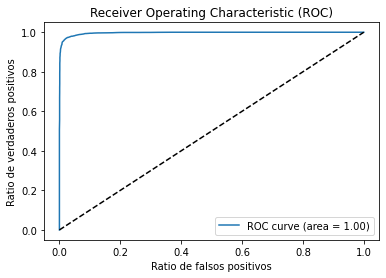

In [28]:
# La curva ROC es una medida de la calidad del modelo para discriminar entre las dos clases, la realizaremos a continuacion:


# Utilizamos la función cross_val_predict para obtener las puntuaciones de las etiquetas predichas para cada instancia
y_scores = cross_val_predict(random_forest, x_train, y_train, cv=5, method="predict_proba")[:, 1]

# Calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

# Graficamos la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('Ratio de falsos positivos')
plt.ylabel('Ratio de verdaderos positivos')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Cuanto mayor sea el área bajo la curva ROC , mejor será la capacidad del modelo para distinguir entre las clases positivas y negativas.

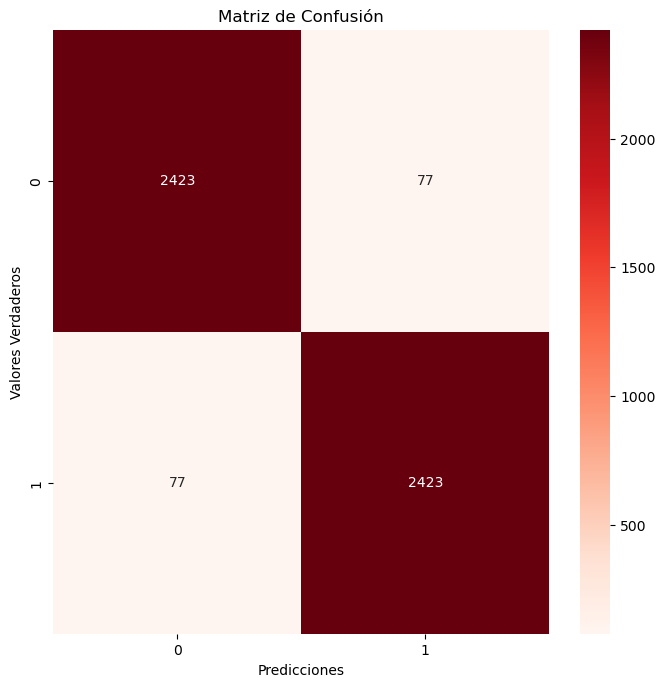

In [29]:
#PREDICCION REAL
df_datos_para_predecir = pd.read_csv("../data/processed/datos_para_predecir.csv")

x = df_datos_para_predecir.drop("permanencia", axis=1)
y = df_datos_para_predecir["permanencia"]

with open('../model/random_forest_model.pkl', 'rb') as file:
    modelo_random_forest = pickle.load(file)
prediccion_real= modelo_random_forest.predict(x)

# generar la matriz de confusión
cm = confusion_matrix(y, prediccion_real)

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
# visualizar la matriz de confusión
sns.heatmap(cm, annot=True, cmap='Reds', ax=ax, fmt='d')



# Configuraciones adicionales
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


In [30]:
# utilizaremos validacion cruzada para dividir el conjunto de datos en 5 partes iguales para entrenar y evaluar la capacidad de generalizacion, evitando sobreajuste y nos ayuda a detectar problemas de cesgo en los datos

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

regresion_logistica = Pipeline(steps=[
    ('scale', StandardScaler()), 
    ('LR', LogisticRegression(random_state=42))
])

f1_cross_val_scores = cross_val_score(regresion_logistica,x_train,y_train,cv=5,scoring='f1')

fig = make_subplots(rows=1, cols=1,shared_xaxes=True,subplot_titles=('Regresion Logistica score'))
fig.add_trace(
    go.Scatter(x=list(range(0,len(f1_cross_val_scores))),y=f1_cross_val_scores,name='Regresión Logistica'),
    row=1, col=1
)

fig.update_layout(height=500, width=900, title_text="Validación cruzada")
fig.update_yaxes(title_text="F1 Score")
fig.show()

NameError: name 'LogisticRegression' is not defined

In [ ]:
regresion_logistica.fit(x_train, y_train)

# Hacer predicciones en el conjunto de datos de prueba
prediccion= regresion_logistica.predict(x_test)


fig = go.Figure(data=[go.Table(header=dict(values=['<b>Modelo<b>', '<b>F1 Score<b>']),                 
cells=dict(values=[['<b>Regression Logistica<b>'], [np.round(f1(prediccion,y_test),2)]]))])
fig.update_layout(title='Resultados')
fig.show()